In [1]:
import gzip
from collections import defaultdict
import random
from tqdm import tqdm
import numpy as np

In [2]:
def readJSON(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [3]:
def parseData(path):
    for l in gzip.open(path, 'rt', encoding="utf8"):
        yield eval(l)
dataset = list(parseData("train.json.gz"))

In [156]:
dataset[0]

{'hours': 0.3,
 'gameID': 'b96045472',
 'hours_transformed': 0.37851162325372983,
 'early_access': False,
 'date': '2015-04-08',
 'text': '+1',
 'userID': 'u01561183'}

## Question 1 {-}

In [4]:
X = [[d['userID'], d['gameID']] for d in dataset]
X_train = X[:165000]
Y_train = [1] * len(X_train)
X_valid = X[165000:]
Y_valid = [1] * len(X_valid)

In [5]:
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
uniqueGames = set()
for d in dataset:
    uniqueGames.add(d['gameID'])
    usersPerGame[d['gameID']].add(d['userID'])
    gamesPerUser[d['userID']].add(d['gameID'])

In [6]:
users = [x[0] for x in X_valid]
for user in users:
    gamesNotPlayed = uniqueGames - gamesPerUser.get(user)
    game = random.choice(list(gamesNotPlayed))
    X_valid.append([user, game])
    Y_valid.append(0)

In [74]:
# Baseline
gameCount = defaultdict(int)
totalPlayed = 0

for user,game,_ in readJSON("train.json.gz"):
    gameCount[game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/2: break

prediction = []    
for pair in X_valid:
    if pair[1] in return1:
        prediction.append(1)
    else:
        prediction.append(0)

In [77]:
print("Accuracy is: ")
sum(1 for x, y in zip(Y_valid, prediction) if x == y) / len(Y_valid)

Accuracy is: 


0.68065

## Question 2 {-}

In [83]:
# I try to find the optimal threshold by plotting the accuracy based on different thresholds
gameCount = defaultdict(int)
totalPlayed = 0

for user,game,_ in readJSON("train.json.gz"):
    gameCount[game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
thres = 0.01
accuracies = []

for _ in range(100):
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed * thres: break

    prediction = []    
    for pair in X_valid:
        if pair[1] in return1:
            prediction.append(1)
        else:
            prediction.append(0)
    
    accuracy = sum(1 for x, y in zip(Y_valid, prediction) if x == y) / len(Y_valid)
    accuracies.append([thres, accuracy])
    
    return1 = set()
    count = 0
    thres = thres + 0.01

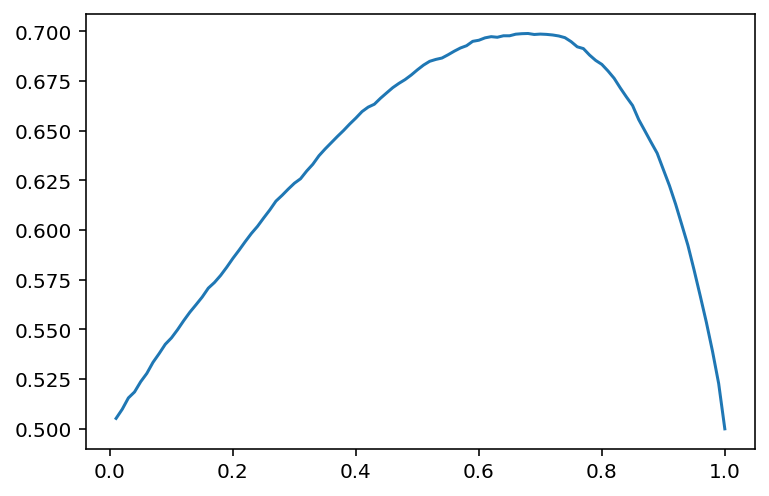

In [86]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
thres_list = [a[0] for a in accuracies]
accuracy_list = [a[1] for a in accuracies]
plt.plot(thres_list, accuracy_list)

In [91]:
best_accuracy = max(accuracy_list)
print("The best threshold is")
print(thres_list[accuracy_list.index(best_accuracy)])
print("With accuracy of " + str(best_accuracy))

The best threshold is
0.6800000000000004
With accuracy of 0.69895


### Question 3 {-}

In [7]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [8]:
def mostSimilar(u, g):
    similarities = []
    games = gamesPerUser[u]
    for g2 in games:
        if g2 == g: continue
        sim = Jaccard(usersPerGame[g], usersPerGame[g2])
        similarities.append((sim,g2))
    similarities.sort(reverse=True)
    return similarities

In [106]:
accuracies = []
thres = 0.001

for _ in range(100):
    preds = []  
    
    for pair in X_valid:
        mostSim = mostSimilar(pair[0], pair[1])[0]
        
        if mostSim >= thres:
            preds.append(1)
        else:
            preds.append(0)
    
    accuracy = sum(1 for x, y in zip(Y_valid, preds) if x == y) / len(Y_valid)
    accuracies.append([thres, accuracy])
    thres = thres + 0.001
    print(thres)

0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011000000000000003
0.012000000000000004
0.013000000000000005
0.014000000000000005
0.015000000000000006
0.016000000000000007
0.017000000000000008
0.01800000000000001
0.01900000000000001
0.02000000000000001
0.02100000000000001
0.022000000000000013
0.023000000000000013
0.024000000000000014
0.025000000000000015
0.026000000000000016
0.027000000000000017
0.028000000000000018
0.02900000000000002
0.03000000000000002
0.03100000000000002
0.03200000000000002
0.03300000000000002
0.03400000000000002
0.035000000000000024
0.036000000000000025
0.037000000000000026
0.03800000000000003
0.03900000000000003
0.04000000000000003
0.04100000000000003
0.04200000000000003
0.04300000000000003
0.04400000000000003
0.04500000000000003
0.046000000000000034
0.047000000000000035
0.048000000000000036
0.04900000000000004
0.05000000000000004
0.05100000000000004
0.05200000000000004
0.05300000000000004
0.05400000000000004
0.05500000000000

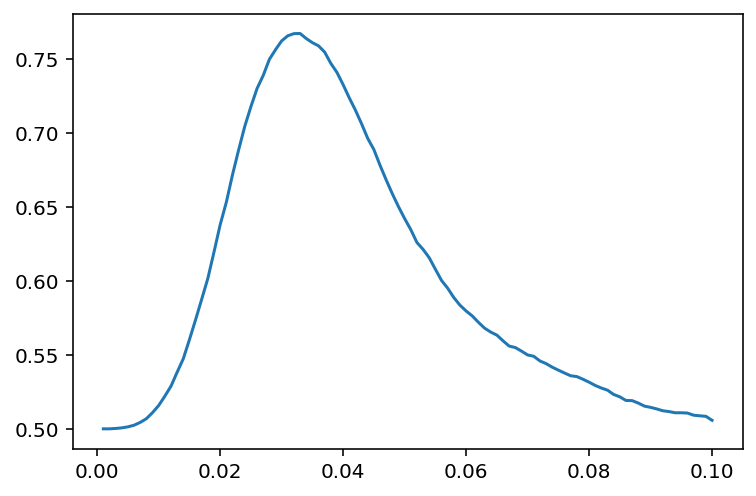

In [107]:
thres_list = [a[0] for a in accuracies]
accuracy_list = [a[1] for a in accuracies]
plt.plot(thres_list, accuracy_list)

In [108]:
best_accuracy = max(accuracy_list)
print("The best threshold is")
print(thres_list[accuracy_list.index(best_accuracy)])
print("With accuracy of " + str(best_accuracy))

The best threshold is
0.03300000000000002
With accuracy of 0.76705


## Question 4 {-}

In [9]:
def getPopularityPred(X, thres):
    gameCount = defaultdict(int)
    totalPlayed = 0
    for user,game,_ in readJSON("train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1
    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()
    return1 = set()
    count = 0
    preds = []
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed * thres: break
    for pair in X:
        if pair[1] in return1:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [10]:
def getJaccardPred(X, thres):
    preds = []  
    for pair in X:
        mostSim = mostSimilar(pair[0], pair[1])
        if mostSim and mostSim[0][0] >= thres:
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [152]:
# Combined Model
accuracies1 = []
accuracies2 = []
for pop_thres in tqdm(np.arange(0.4, 0.85, 0.01)):
    pops = getPopularityPred(X_valid, pop_thres)
    for jac_thres in np.arange(0.024, 0.044, 0.002):
        jaccards = getJaccardPred(X_valid, jac_thres)
        combined_preds1 = []
        combined_preds2 = []

        for p_pred, j_pred in zip(pops, jaccards):
            if p_pred == j_pred:
                combined_preds1.append(p_pred)
                combined_preds2.append(p_pred)
            elif p_pred > j_pred:
                combined_preds1.append(p_pred)
                combined_preds2.append(j_pred)
            else:
                combined_preds1.append(j_pred)
                combined_preds2.append(p_pred)

        accuracy1 = sum(1 for x, y in zip(Y_valid, combined_preds1) if x == y) / len(Y_valid)
        accuracies1.append([accuracy1, pop_thres, jac_thres])
        accuracy2 = sum(1 for x, y in zip(Y_valid, combined_preds2) if x == y) / len(Y_valid)
        accuracies2.append([accuracy2, pop_thres, jac_thres])

  2%|▊                                       | 1/50 [11:20<9:15:46, 680.54s/it]


KeyboardInterrupt: 

In [140]:
print("The accuracy of the combined model on validation set is " + str(accuracy))

The accuracy of the combined model on validation set is 0.74945


## Question 5 {-}

#### Kaggle Username: KelvinSh {-}

In [20]:
X_test = []
predictions = open("predictions_Played.txt", 'w')
for l in open("pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    X_test.append([u,g,-1])
    
pops = getPopularityPred(X_test, 0.79)
jaccards = getJaccardPred(X_test, 0.027)
combined_preds = []

for p_pred, j_pred in zip(pops, jaccards):
    if p_pred == j_pred:
        combined_preds.append(p_pred)
    elif p_pred > j_pred:
        combined_preds.append(j_pred)
    else:
        combined_preds.append(p_pred)

for pair, y in zip(X_test, combined_preds):
    predictions.write(pair[0] + '-' + pair[1] + "," + str(y) + "\n")
    
predictions.close()

In [1]:
a = 5
%store a

Stored 'a' (int)
